# Baynes climatology

In [2]:
import numpy as np
import xarray as xr
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import os
from itertools import repeat, chain
from datetime import datetime, timedelta
from dateutil.parser import parse
from scipy.signal import butter, lfilter
from salishsea_tools import places, utilities, viz_tools
from timeseries_extras import load_hindcast_timeseries_location

%matplotlib inline

### Preview HRDPS record at Sentry Shoal

In [3]:
# Connect HRDPS object to ERDDAP source and specify date and location parameters
HRDPS = xr.open_dataset('https://salishsea.eos.ubc.ca/erddap/griddap/ubcSSaSurfaceAtmosphereFieldsV1')
mask = xr.open_dataset('/data/bmoorema/MEOPAR/grid/mesh_mask201702.nc')
path_NEMO = '/results/SalishSea/hindcast.201812'
path_NEMO_annex = '/results2/SalishSea/hindcast.201812_annex'
daterange = [datetime(2014, 9, 12), datetime(2019, 2, 19)]
j, i = places.PLACES['Sentry Shoal']['GEM2.5 grid ji']

In [7]:
# Load netCDF data from ERDDAP in 6 month chunks
time = np.empty(0)
v_wind = np.empty(0)
bar = utilities.statusbar('Loading ...')
for interval in bar(range(int(np.diff(daterange)[0].days/180))):
    dateslice = slice(*[daterange[0] + timedelta(days=i*180) for i in [interval, interval+1]])
    time = np.concatenate((time, HRDPS.time.sel(time=dateslice).values.astype('datetime64[s]').astype(datetime)))
    v_wind = np.concatenate((v_wind, HRDPS.v_wind.sel(time=dateslice).isel(gridY=j, gridX=i).values))

# Filter HRDPS record
fs = 1 / 3600
cutoff = 1 / 86400 / 7
v_filt = lfilter(*butter(2, cutoff / fs / 0.5, btype='lowpass'), v_wind)

Loading ... 100% (9 of 9) |#############################################################################|Time: 0:03:38


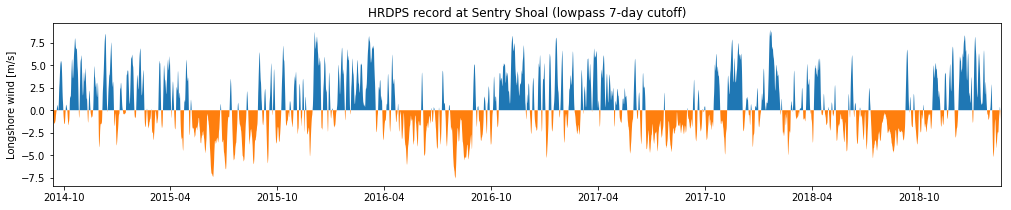

In [14]:
# Plot filtered HRDPS magnitude and angle record
fig, ax = plt.subplots(1, 1, figsize=(17, 3))
ax.set_xlim(daterange)
ax.set_title('HRDPS record at Sentry Shoal (lowpass 7-day cutoff)')
for where in [v_filt>0, v_filt<0]:
    ax.fill_between(time, v_filt, where=where)
ax.set_ylabel('Longshore wind [m/s]')
plt.show()

### Browse through specific upwelling events

In [83]:
# Upwelling event date windows
eventwindows = [
    [parse(date) for date in window] for window in [
        ['2015 Apr 26 00:00', '2015 Apr 28 12:00'],
        ['2015 Jun 07 00:00', '2015 Jun 13 18:00'],
        ['2015 Jun 30 06:00', '2015 Jul 05 00:00'],
        ['2015 Jul 16 00:00', '2015 Jul 20 12:00'],
        ['2015 Jul 31 06:00', '2015 Aug 05 12:00'],
        ['2015 Sep 11 18:00', '2015 Sep 14 18:00'],
        ['2015 Sep 18 12:00', '2015 Sep 20 08:00'],
        ['2016 Apr 11 18:00', '2016 Apr 14 06:00'],
        ['2016 May 04 00:00', '2016 May 10 00:00'],
        ['2016 Jun 02 20:00', '2016 Jun 08 00:00'],
        ['2016 Jul 07 12:00', '2016 Jul 09 04:00'],
        ['2016 Jul 26 00:00', '2016 Jul 31 18:00'],
        ['2016 Aug 10 12:00', '2016 Aug 23 18:00'],
        ['2017 Apr 04 12:00', '2017 Apr 11 00:00'],
        ['2017 May 30 12:00', '2017 Jun 03 12:00'],
        ['2017 Jul 21 12:00', '2017 Jul 26 00:00'],
        ['2017 Sep 09 00:00', '2017 Sep 15 00:00'],
        ['2018 Apr 08 06:00', '2018 Apr 14 00:00'],
        ['2018 Jul 11 20:00', '2018 Jul 14 20:00'],
        ['2018 Sep 07 12:00', '2018 Sep 12 00:00'],
    ]
]

eventwindows = [
    [parse(date) for date in window] for window in [
        ['2015 Apr 26 12:00', '2015 Apr 28 12:00'],
        ['2016 May 08 02:00', '2016 May 08 12:00'],
        ['2017 Jun 15 00:00', '2017 Jun 17 00:00'],
        ['2018 Sep 09 00:00', '2018 Sep 11 00:00'],
    ]
]

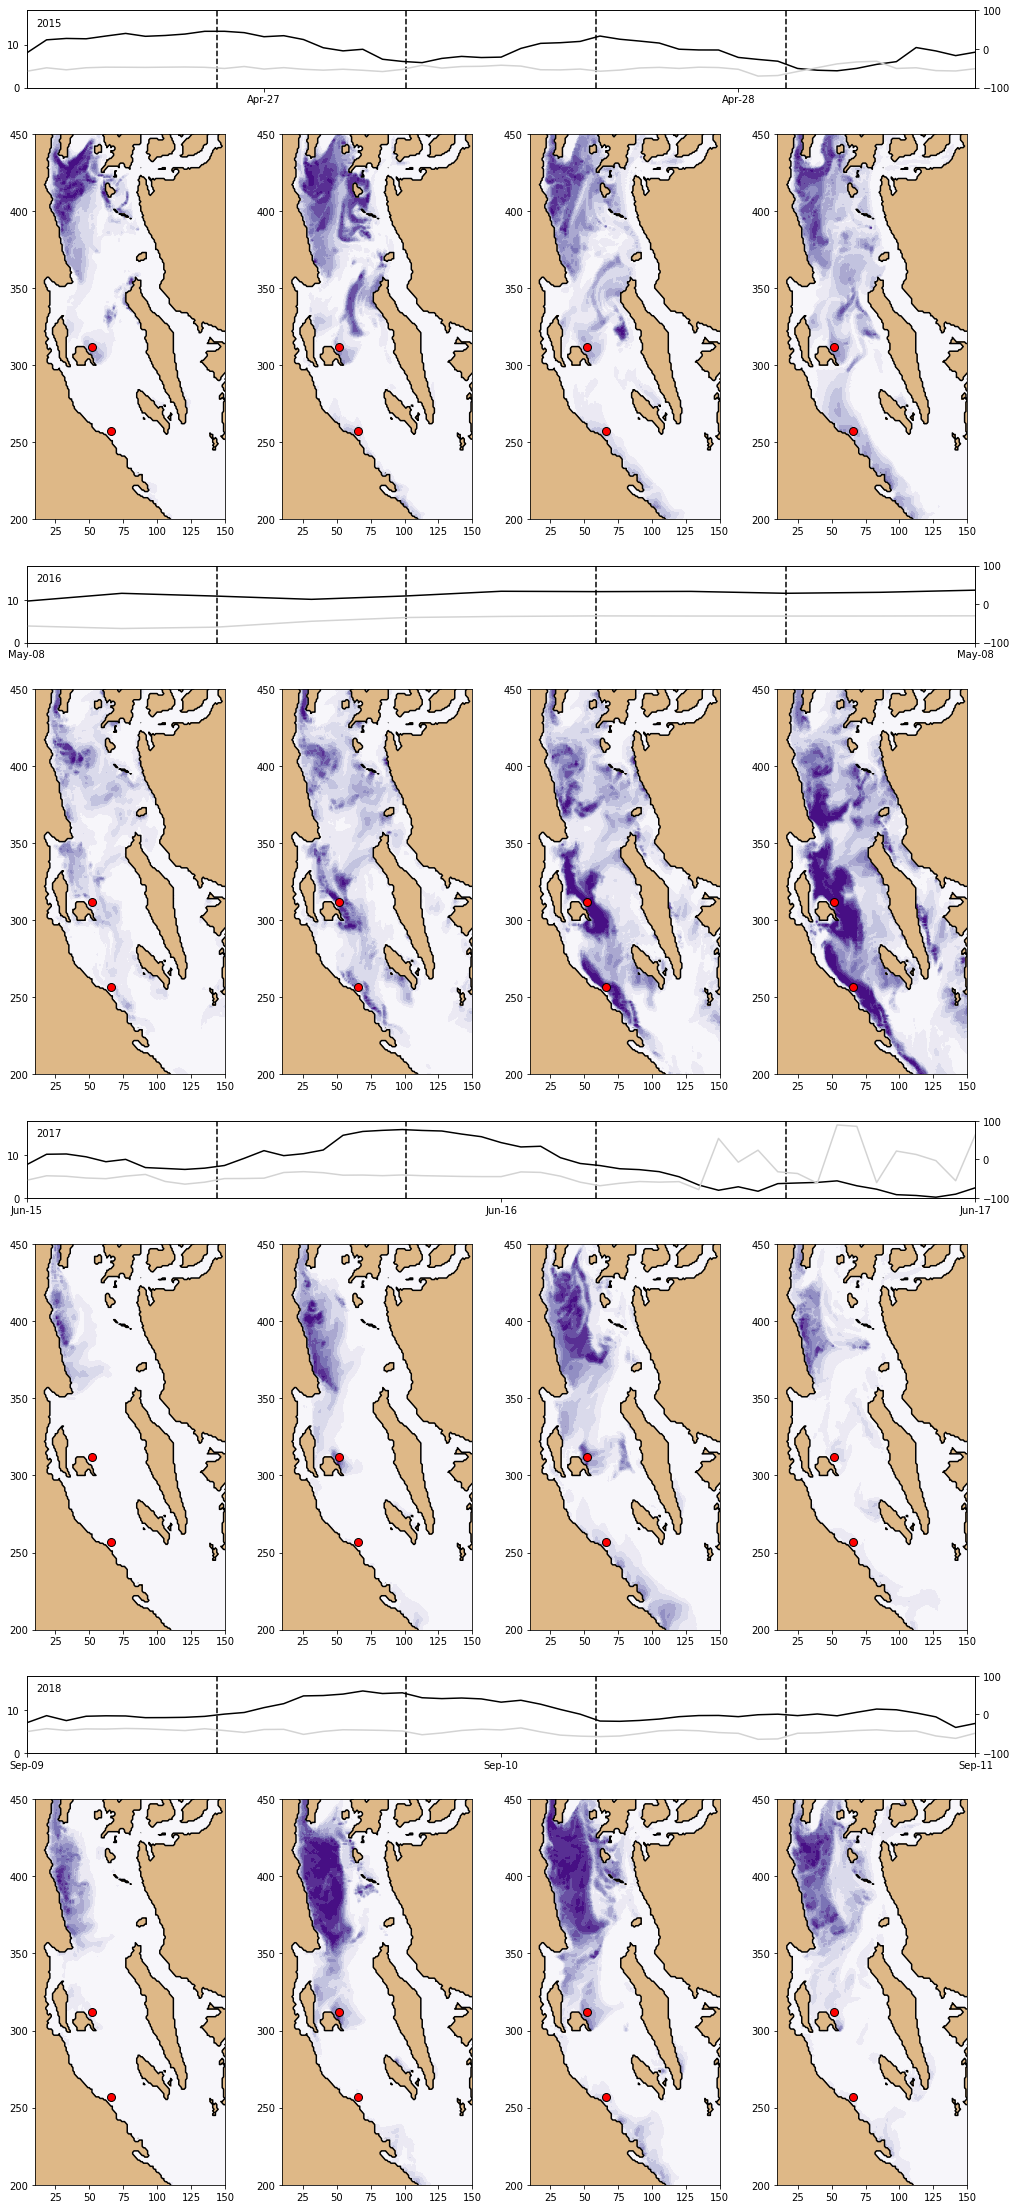

In [84]:
# Make figure layout
fig = plt.figure(figsize=(17, 10*len(eventwindows)))
height_ratios = list(chain(*repeat([1, 5], len(eventwindows))))
gs = GridSpec(len(eventwindows)*2, 4, height_ratios=height_ratios)
xrange = [100, 398]
yrange = [300, 898]

# Loop though event windows
for row, eventwindow in zip(range(0, len(eventwindows)*2, 2), eventwindows):
    
    # Extract HRDPS data
    eventlist = [HRDPS.sel(time=slice(*eventwindow)).isel(gridY=j, gridX=i)[key].values for key in ['u_wind', 'v_wind']]
    event = {
        'time': HRDPS.sel(time=slice(*eventwindow)).time.values.astype('datetime64[s]').astype(datetime),
        'magnitude': np.sqrt(sum([component**2 for component in eventlist])),
        'angle': np.degrees(np.arctan(np.divide(*eventlist[::-1])))
    }
    
    # Plot HRDPS data
    ax = fig.add_subplot(gs[row, :])
    ax.set_xlim(eventwindow)
    ax.text(0.01, 0.8, eventwindow[0].year, transform=ax.transAxes)
    for axis, key, color, ylim in zip([ax, ax.twinx()], ['magnitude', 'angle'], ['black', 'lightgray'], [[0, 18], [-100, 100]]):
        axis.plot(event['time'], event[key], '-', color=color)
        axis.xaxis.set_major_locator(mdates.DayLocator())
        axis.xaxis.set_major_formatter(mdates.DateFormatter('%b-%d'))
        axis.set_ylim(ylim)
    
    # Loop through individual dates
    for col in range(4):
        
        # Extract NEMO data
        date = eventwindow[0] + (col + 1) * np.diff(eventwindow)[0] / 5
        datestr = date.strftime('%Y%m%d')
        if date.year > 2016:
            path = path_NEMO_annex
        else:
            path = path_NEMO
        fn = os.path.join(path, date.strftime('%d%b%y').lower(), f'SalishSea_1h_{datestr}_{datestr}_mtrc_T.nc')
        data = xr.open_dataset(fn).sel(time_counter=date, method='nearest')
        
        # Plot NEMO data
        ax_map = fig.add_subplot(gs[row+1, col])
        c = ax_map.contourf(data.x, data.y, data.tracer20m[0, ...], levels=np.arange(0, 1.1, 0.1), cmap=plt.get_cmap('Purples'), extend='both')
        ax_map.contourf(mask.tmask[0, 0, slice(*yrange), slice(*xrange)], levels=[-0.01, 0.01], colors='Burlywood')
        ax_map.contour(mask.tmask[0, 0, slice(*yrange), slice(*xrange)], levels=[-0.01, 0.01], colors='k')
        ax_map.plot(52, 312, 'ko', markerfacecolor='r', markersize=8)
        ax_map.plot(66, 257, 'ko', markerfacecolor='r', markersize=8)
        ax_map.set_xlim([10, 150])
        ax_map.set_ylim([200, 450])
        viz_tools.set_aspect(ax_map)
        
        # Mark date on HRDPS record
        ax.plot([date, date], [0, 18], 'k--')

In [4]:
# Load surface tracer timeseries at Hornby and Qualicum (from Salish command line)
locs = {'Hornby': (52, 312, 0), 'Qualicum': (66, 257, 0)}
daterange = ['2015 Jan 1', '2018 Dec 31']
loadpath = '/results/SalishSea/hindcast.201812'
loadpath_cutoff = '/results2/SalishSea/hindcast.201812_annex'

load_hindcast_timeseries_location(
    ['tracer20m'], locs, daterange, loadpath, '~/Desktop', ftype='mtrc_T',
    date_cutoff='2016 Nov 21', loadpath_cutoff=loadpath_cutoff,
)

Loading NEMO record ... 100% (2 of 2) |####################################|Time: 0:01:03


In [11]:
# Load saved timeseries from xarry files
prefix = '/ocean/bmoorema/research/MEOPAR/analysis-ben/data/hindcast201812_20150101_20181231_'
data = {}
for key in locs:
    data[key] = xr.open_dataset(prefix + key + '_tracer20m.nc')

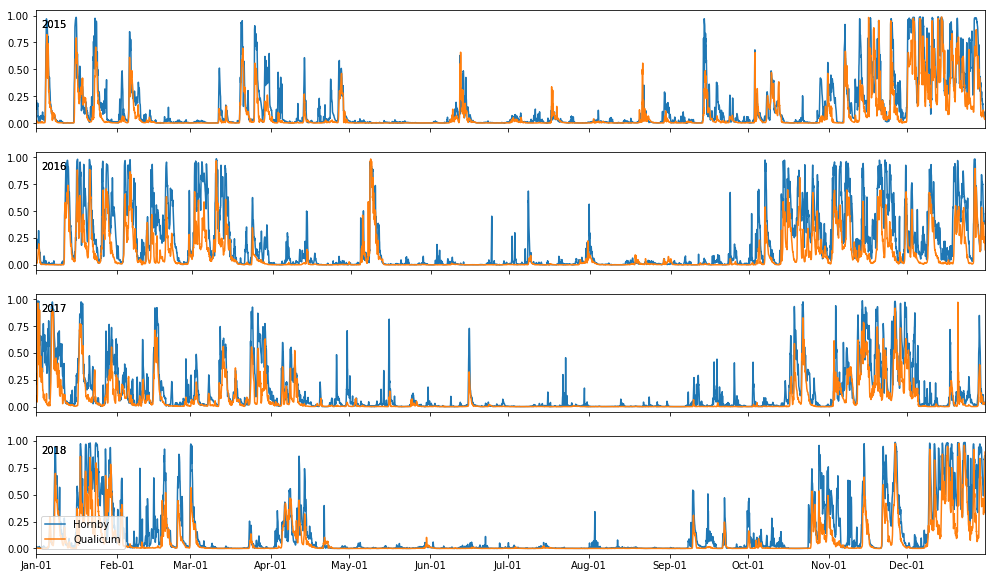

In [22]:
fig, axs = plt.subplots(4, 1, figsize=(17, 10))
for ax, year in zip(axs, range(2015, 2019)):
    for key in locs:
        ax.plot(data[key].time, data[key].tracer20m, label=key)
        ax.set_xlim([datetime(year, 1, 1), datetime(year, 12, 31)])
        ax.set_ylim(-0.05, 1.05)
        ax.xaxis.set_major_locator(mdates.MonthLocator())
        ax.xaxis.set_major_formatter(mdates.DateFormatter('%b-%d'))
        ax.text(0.005, 0.85, str(year), transform=ax.transAxes)
        if year < 2018:
            ax.xaxis.set_ticklabels('')
axs[3].legend(loc=3)
plt.show()